# Course 1: Classical Generative Diffusion Models

## Intro to Deep Learning with Pytorch

### Manipulating tensors, transfer between CPU and GPU devices

In [1]:
import torch

def get_device():
    """
    Returns the available device ('cuda', 'mps', or 'cpu').
    """
    if torch.cuda.is_available():
        return 'cuda'
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'
    
device = get_device()
print('Device in use:', device)

Device in use: mps


**Simply creating tensors**

In [5]:
# create a torch.tensor from a list
x = torch.tensor([1, 2, 3])
print(x)

# create a torch.tensor from a numpy array is as straightforward
import numpy as np
x = np.array([1, 2, 3])
x = torch.tensor(x)
print(x)

# also works with a list of lists
x = [[1, 2], [3, 4]]
x = torch.tensor(x)
print(x)


tensor([1, 2, 3])
tensor([1, 2, 3])
tensor([[1, 2],
        [3, 4]])


**Tensors operations** Typically element wise operations

In [11]:
# element-wise operations
x = torch.tensor([1, 2, 3]).to(device)
y = torch.tensor([4, 5, 6]).to(device)
add = x + y
print('add', add)
mul = x * y
print('mul', mul)

add tensor([5, 7, 9], device='mps:0')
mul tensor([ 4, 10, 18], device='mps:0')


**stacking tensors**

In [7]:
# you can stack multiple tensors together. See how the shape changes
x = torch.tensor([1, 2, 3])
y = torch.tensor([4, 5, 6])
print('x xhape:', x.shape)
print('y shape:', y.shape)
z = torch.stack([x, y])
print('z shape:', z.shape)

x xhape: torch.Size([3])
y shape: torch.Size([3])
z shape: torch.Size([2, 3])


**Special tensors: zero and one tensors**

In [10]:
# create a tensor filled with zeros of dimension 2x3
x = torch.zeros(2, 3)
y = torch.ones(2, 3)
print('x', x)
print('y', y)

# IMPORTANT : you can create a tensor filled with zeros with the SAME SHAPE as another tensor AND ON THE SAME DEVICE
x = torch.tensor([1, 2, 3]).to(device)
z = torch.zeros_like(x)
print('z', z)


x tensor([[0., 0., 0.],
        [0., 0., 0.]])
y tensor([[1., 1., 1.],
        [1., 1., 1.]])
z tensor([0, 0, 0], device='mps:0')


**Draw random variables**

In [13]:
# Sample a tensor from a uniform distribution
x = torch.rand(2, 3)
print('x', x)

# Sample a tensor from a normal distribution
y = torch.randn(2, 3)
print('y', y)

x tensor([[0.6101, 0.0578, 0.4999],
        [0.9809, 0.9347, 0.0876]])
y tensor([[ 0.5097, -0.7659, -0.1919],
        [ 0.7768,  0.6207, -1.2120]])


### Example CPU vs GPU: Mandelbrot

In [ ]:
# create a grid of complex numbers
lim = 1.5
x = torch.linspace(-lim, lim, 300)
y = torch.linspace(-lim, lim, 300)
X, Y = torch.meshgrid(x, y)
C = X + 1j*Y
C = C.to(device) # comment out to test on CPU
print('C shape:', C.shape)

# A point is in the Mandelbrot set if: z_{n+1} = z_n^2 + c does not diverge
# We can use torch to compute the Mandelbrot set
def mandelbrot(c, max_iter):
    z = torch.zeros_like(c)
    for _ in range(max_iter):
        z = z*z + c
    
    # the point is in the Mandelbrot set if the absolute value of z is less than 2
    in_mandelbrot = z.cpu().abs() < 2
    return in_mandelbrot

In [75]:
# C = C.to(device)
%timeit Z = mandelbrot(C, 50)

3.34 ms ± 59.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


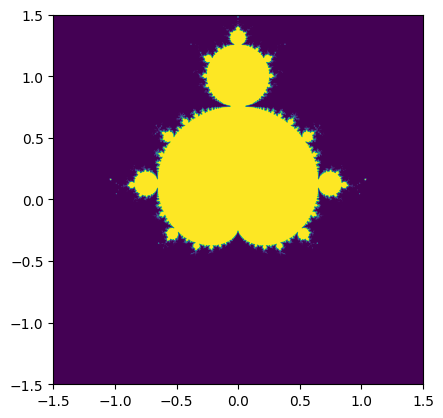

In [76]:
# plot the Mandelbrot set
import matplotlib.pyplot as plt
plt.imshow(Z.numpy(), extent=(-lim, lim, -lim, lim))
plt.show()

### Preparing data: Dataset and Dataloader

Using Gaussian Mixture dataset, with parameters mean=[-0.5, 0.0], [0.5, 0.0] and std=0.1. 10000 samples.


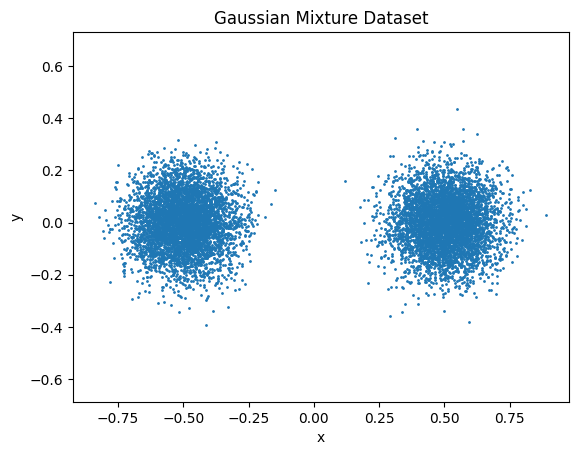

In [2]:
import torch

# Create a dataset with a Gaussian mixture distribution:
def get_gaussian_mixture_datapoints(mean1, mean2, std, n_samples):
    print('Using Gaussian Mixture dataset, with parameters mean=[{}, {}], [{}, {}] and std={}. {} samples.'
          .format(mean1[0], mean1[1], mean2[0], mean2[1], std, n_samples))
    # Half the samples from each mixture component.
    samples1 = torch.randn(n_samples // 2, 2) * std + mean1
    samples2 = torch.randn(n_samples - n_samples // 2, 2) * std + mean2
    samples = torch.concatenate([samples1, samples2], dim=0)
    return samples

def get_default_gaussian_mixture_datapoints():
    mean1 = torch.tensor([-0.5, 0])
    mean2 = torch.tensor([0.5, 0])
    std = 0.1
    n_samples = 10000
    gaussian_datapoints = get_gaussian_mixture_datapoints(mean1, mean2, std, n_samples)
    gaussian_datapoints = gaussian_datapoints[torch.randperm(n_samples)]
    return gaussian_datapoints

# random shuffle
gaussian_datapoints = get_default_gaussian_mixture_datapoints()

# plot the Gaussian mixture dataset
import matplotlib.pyplot as plt
plt.scatter(gaussian_datapoints[:, 0], gaussian_datapoints[:, 1], s=1)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian Mixture Dataset')
plt.show()


In [ ]:
# Create a TensorDataset
def create_dataset(datapoints):
    
    labels = torch.zeros(datapoints.shape[0])
    dataset_obj = torch.utils.data.TensorDataset(datapoints, labels)
    return dataset_obj

def create_dataloader(dataset, batch_size):
    # Create a DataLoader
    dataloader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True
        )
    return dataloader


gaussian_datapoints = get_default_gaussian_mixture_datapoints()
dataset_obj = create_dataset(gaussian_datapoints)
dataloader = create_dataloader(dataset_obj, batch_size=500)

Using Gaussian Mixture dataset, with parameters mean=[-0.5, 0.0], [0.5, 0.0] and std=0.1. 10000 samples.


### Evaluation metric: assess the distance between two empirical distribution

We will use the Wassertein-2 metric:
$$W_2(\mu, \nu) = \underset{\gamma \in \mathcal{M}(\mu, \nu)}{\inf} \int \| x - y \|^2 \gamma(dx, dy). $$

In [4]:
import pyemd

# Run emd_loss on two gaussian with different means and same std
mean1 = torch.tensor([-0.5, 0])
mean2 = torch.tensor([0.5, 0])
std1 = 0.1
std2 = 0.1
n_samples = 10000
gaussian_1 = torch.randn(n_samples, 2) * std1 + mean1
gaussian_2 = torch.randn(n_samples, 2) * std2 + mean2

# Compute the EMD between the two distributions
emd = pyemd.emd_samples(gaussian_1, gaussian_2)

print('Empirical EMD between the two distributions:', emd)

Empirical EMD between the two distributions: 0.4994891085476188


## Generative Diffusion Process

We need to define three functions:
* **The forward diffusion**, i.e., sample $x_t$ given $x_0, t$. Since $p_{t |0}$ is available in closed form, we do not need to simulate a forward SDE; this is the *the simulation-free* property.
* **The objective function**, which is the denoising squared $L_2$ loss.
* **The sampling algorithm**, i.e., a simulation of the backward SDE.

### Forward : sample $p_{t | 0}$

Implement two noise schedule:
* **linear noise schedule** $\beta_t$ scales linearly from $\beta_{min} = 0.1$ to $\beta_{max} = 20.0$.
* **cosine noise schedule** Directly parameterize $\bar \alpha_t$ as 
$$\bar \alpha_t = \cos(\frac{\bar t + s}{2(1 + s)} \pi)^2,$$ 
where $s = 0.008$ and $\bar  t = t / T$


In [9]:
import math

def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

def compute_beta_t(t_norm, T, schedule = 'linear'):
    # Compute β(t) depending on schedule.
    
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        beta_t = beta_min + t_norm * (beta_max - beta_min)
    elif schedule == 'cosine':
        s = 0.008
        beta_t = (torch.pi / (T * (1 + s))) * torch.tan(((t_norm + s) / (1 + s)) * (torch.pi / 2))
    else:
        raise ValueError('Unknown schedule')
    return beta_t

def compute_alpha_bar(t_norm, schedule = 'linear'):
    if schedule == 'linear': 
        beta_min = 0.1
        beta_max = 20.0
        integrated_beta = beta_min * t_norm + 0.5 * (beta_max - beta_min) * t_norm**2
        alpha_bar = torch.exp(-  integrated_beta)
    elif schedule == 'cosine':
        alpha_bar = 0.5 * (1 - torch.cos(t_norm * torch.pi))
        s = 0.008
        alpha_bar = torch.cos((t_norm + s) / (1 + s) * (torch.pi / 2))**2
    else:
        raise ValueError('Unknown schedule')
    return alpha_bar

# must return x_t and the added noise, we will need it later to compute the loss
def forward(x_start, t, T, schedule = 'linear'):
    t_norm = t / T 
    alpha_bar = compute_alpha_bar(t_norm, schedule)
    # expand alpha_bar to the same shape as x_start, so that we can multiply them
    alpha_bar = match_last_dims(alpha_bar, x_start.shape)
    noise = torch.randn_like(x_start)
    x_t = torch.sqrt(alpha_bar)*x_start + torch.sqrt(1 - alpha_bar)*noise
    return x_t, noise

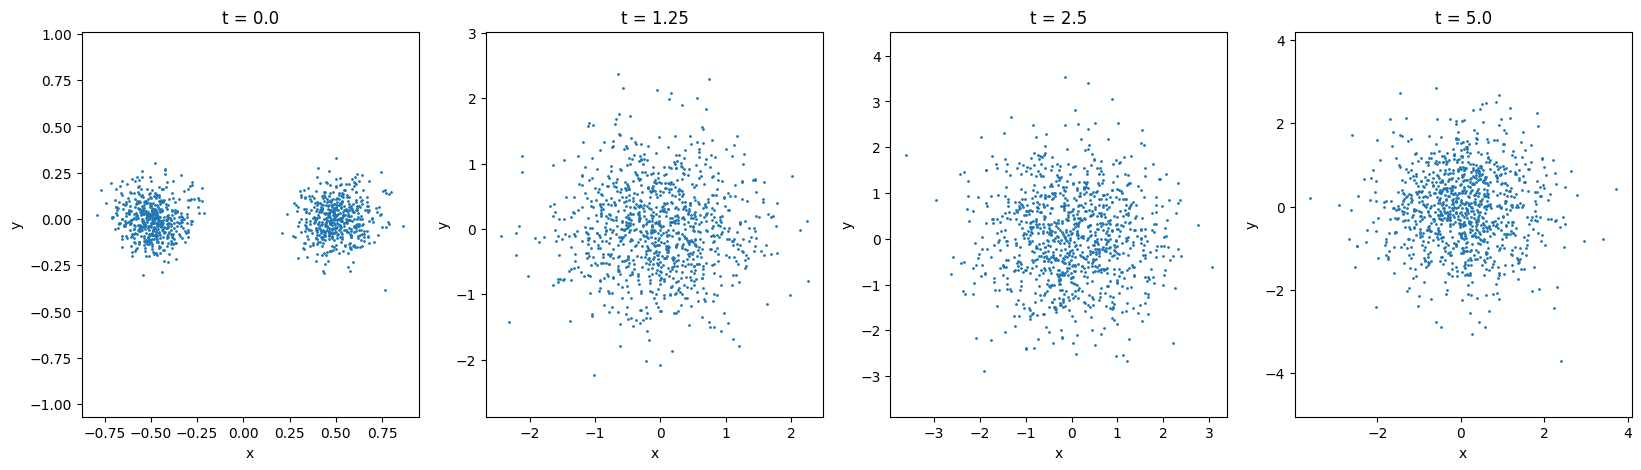

In [21]:

# check the forward process by plotting the empirical marginals p_t, for some t and empirical samples
x_start = dataset_obj[:1000][0]

# create four subplots 
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# plot the empirical marginals p_t
def plot_ax_i(ax, x, y, title):
    ax.scatter(x, y, s=1)
    ax.axis('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)

T = 5

for i, t_norm in enumerate([0.0, 0.25, 0.5, 1.0]):
    t = t_norm * T * torch.ones_like(x_start)[:, 0]
    x_t, _ = forward(x_start, t, T)
    plot_ax_i(axs[i], x_t[:, 0], x_t[:, 1], 't = {}'.format(t[0]))

plt.show()




### Training and Setting up the Neural Network

**Neural network**

In [ ]:
from model.SimpleModel import MLPModel

# define a simple MLP model. For the moment, take the default one I provide

simple_model = MLPModel(
    nfeatures = 2,
    time_emb_type = 'learnable',
    time_emb_size= 8,
    nblocks = 4,
    nunits = 32,
    skip_connection = True,
    layer_norm = True,
    dropout_rate = 0.1,
    learn_variance = False,
)

simple_model = simple_model.to(device)

# setting up the optimizer
import torch.optim as optim

optimizer = optim.AdamW(
    simple_model.parameters(), 
    lr=2e-3, 
    betas=(0.9, 0.999))

# potentially set up a learning schedule too ...

**Objective function**

In [ ]:
import torch.nn.functional as F

def training_losses(model, x_start, T):
    x_start = x_start.to(device)
    batch_size = x_start.shape[0]
    # Sample t uniformly from [0, T]
    t = torch.rand(batch_size, device=device) * T
    x_t, noise = forward(x_start, t, T)
    # The model takes x_t and t as input and predicts the noise. time t should be of shape (batch_size, 1)
    # we can pass normalized time to model as input
    t_norm = t / T
    t_norm = t_norm.view(-1, 1)
    predicted_noise = model(x_t, t_norm)
    loss = F.mse_loss(predicted_noise, noise)
    return loss

# training loop

import os

def train(
    num_epochs, 
    checkpoint_interval, 
    dataloader,
    model,
    optimizer,
    checkpoint_dir,
    device,
    T = 1
):
    print("Training on device:", device)

    # Set the model to training mode.
    model.train()
    epoch_losses = []
    for epoch in (range(1, num_epochs + 1)):
        running_loss = 0.0
        for batch_idx, (data, _) in (enumerate(dataloader)):
            data = data.to(device) 
            optimizer.zero_grad()

            # Compute the training loss.
            loss = training_losses(model, x_start=data, T=T)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # if batch_idx % 100 == 0:
            #     print(f"Epoch [{epoch}] Batch [{batch_idx}] Loss: {loss.item():.4f}")

        avg_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

        # Save a checkpoint every checkpoint_interval epochs.
        if epoch % checkpoint_interval == 0:
            os.makedirs(checkpoint_dir, exist_ok=True)
            checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch_losses': epoch_losses,
            }, checkpoint_path)
            print("Saved checkpoint to", checkpoint_path)

    print("Training finished.")

In [55]:
# RUN!
train(
    num_epochs=50,
    checkpoint_interval=50,
    dataloader=dataloader,
    model=simple_model,
    optimizer=optimizer,
    checkpoint_dir='checkpoints',
    device=device
)

Training on device: mps
Epoch [1] Average Loss: 0.4359
Epoch [2] Average Loss: 0.2437
Epoch [3] Average Loss: 0.1982
Epoch [4] Average Loss: 0.1813
Epoch [5] Average Loss: 0.1733
Epoch [6] Average Loss: 0.1676
Epoch [7] Average Loss: 0.1652
Epoch [8] Average Loss: 0.1633
Epoch [9] Average Loss: 0.1620
Epoch [10] Average Loss: 0.1570
Epoch [11] Average Loss: 0.1573
Epoch [12] Average Loss: 0.1489
Epoch [13] Average Loss: 0.1475
Epoch [14] Average Loss: 0.1505
Epoch [15] Average Loss: 0.1465
Epoch [16] Average Loss: 0.1457
Epoch [17] Average Loss: 0.1455
Epoch [18] Average Loss: 0.1376
Epoch [19] Average Loss: 0.1343
Epoch [20] Average Loss: 0.1273
Epoch [21] Average Loss: 0.1272
Epoch [22] Average Loss: 0.1238
Epoch [23] Average Loss: 0.1272
Epoch [24] Average Loss: 0.1216
Epoch [25] Average Loss: 0.1200
Epoch [26] Average Loss: 0.1120
Epoch [27] Average Loss: 0.1160
Epoch [28] Average Loss: 0.1158
Epoch [29] Average Loss: 0.1236
Epoch [30] Average Loss: 0.1151
Epoch [31] Average Loss: 

### Generation: simulate the backward SDE

In [56]:
from tqdm import tqdm

def score_fn(model, x, t_norm):
    """
    Given the noise-predicting model, returns the score (i.e. ∇_x log p_t(x))
    at actual time t. Note that the model expects a normalized time (t/T).
    For VP: score = - (predicted noise) / sqrt(1 - ᾱ(t))
    """

    alpha_bar = compute_alpha_bar(t_norm).view(-1, *([1] * (x.dim() - 1)))
    epsilon = model(x, t_norm.view(-1, 1))
    score = - epsilon / torch.sqrt(1 - alpha_bar)
    return score

def sample(
    model,
    n_samples,
    reverse_steps,
    schedule = 'linear',
    T = 1):
    shape = (n_samples, 2)
    xt = torch.randn(shape, device=device)
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(T, 0, reverse_steps + 1, device=device)
        for i in tqdm(range(reverse_steps)):
            t_current = t_seq[i]
            t_next = t_seq[i + 1]
            dt = t_next - t_current  # dt is negative (reverse time)
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t_current, device=device)
            t_norm_batch = t_batch / T

            
            beta_t = compute_beta_t(t_norm_batch, T, schedule)
            beta_t = beta_t.view(-1, *([1] * (xt.dim() - 1)))
            
            
            f = -0.5 * beta_t * xt
            g = torch.sqrt(beta_t)
            
            
            # Get the score (using the noise-predicting network)
            score = score_fn(model, xt, t_batch)
            
            # Euler–Maruyama update:
            #   x = x + [f - g^2 * score] dt + g * sqrt(-dt) * z,   where z ~ N(0, I)
            z = torch.randn_like(xt)
            
            xt = xt + (f - (g**2) * score) * dt + g * torch.sqrt(-dt) * z
            
    return xt

In [ ]:
samples = sample(
    model=simple_model,
    n_samples=1000,
    reverse_steps=100,
    schedule='linear',
    T=1
)
samples = samples.cpu().detach().numpy()

# plot samples
tmp_samples = samples.clip(-1, 1)
plt.scatter(tmp_samples[:, 0], tmp_samples[:, 1], s=1)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title('Generated Samples')
plt.show()

100%|██████████| 100/100 [00:00<00:00, 273.04it/s]


# Case Study 1: SDE vs ODE sampling

Modify the `sample` function to accept a `deterministic : bool` argument, according to which the sampling procedure will correspond to SDE or ODE sampling.

In [59]:
def score_fn(model, x, t_norm):
    """
    Given the noise-predicting model, returns the score (i.e. ∇_x log p_t(x))
    at actual time t. Note that the model expects a normalized time (t/T).
    For VP: score = - (predicted noise) / sqrt(1 - ᾱ(t))
    """

    alpha_bar = compute_alpha_bar(t_norm).view(-1, *([1] * (x.dim() - 1)))
    epsilon = model(x, t_norm.view(-1, 1))
    score = - epsilon / torch.sqrt(1 - alpha_bar)
    return score

def sample(
    model,
    n_samples,
    reverse_steps,
    deterministic = False,
    schedule = 'linear',
    T = 1):
    shape = (n_samples, 2)
    xt = torch.randn(shape, device=device)
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(T, 0, reverse_steps + 1, device=device)
        for i in tqdm(range(reverse_steps)):
            t_current = t_seq[i]
            t_next = t_seq[i + 1]
            dt = t_next - t_current  # dt is negative (reverse time)
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t_current, device=device)
            t_norm_batch = t_batch / T

            
            beta_t = compute_beta_t(t_norm_batch, T, schedule)
            beta_t = beta_t.view(-1, *([1] * (xt.dim() - 1)))
            
            
            f = -0.5 * beta_t * xt
            g = torch.sqrt(beta_t)
            
            
            # Get the score (using the noise-predicting network)
            score = score_fn(model, xt, t_batch)
            
            if deterministic:
                xt = xt + (f - (g**2) * score / 2) * dt
            else:
                # Euler–Maruyama update:
                #   x = x + [f - g^2 * score] dt + g * sqrt(-dt) * z,   where z ~ N(0, I)
                z = torch.randn_like(xt)
                xt = xt + (f - (g**2) * score) * dt + g * torch.sqrt(-dt) * z
            
    return xt

In [ ]:
samples = sample(
    model=simple_model,
    n_samples=1000,
    reverse_steps=20,
    deterministic=True,
    schedule='linear',
    T=1
)
samples = samples.cpu().detach().numpy()

# plot samples
tmp_samples = samples.clip(-1, 1)
plt.scatter(tmp_samples[:, 0], tmp_samples[:, 1], s=1)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title('Generated Samples')
plt.show()

100%|██████████| 20/20 [00:00<00:00, 241.09it/s]


Make a plot comparing the performance of SDE vs ODE sampling as a function of reverse steps, for example using the Wasserstein-2 metric.

In [64]:
# now compare ODE vs SDE performance

timesteps = [2, 5, 10, 20, 50, ]
n_samples = 5000

samples_sde = [sample(
    model=simple_model,
    n_samples=n_samples,
    reverse_steps=steps,
    deterministic=False,
    schedule='linear',
    T=1
) for steps in timesteps]

samples_ode = [sample(
    model=simple_model,
    n_samples=n_samples,
    reverse_steps=steps,
    deterministic=True,
    schedule='linear',
    T=1
) for steps in timesteps]

# retrieve true samples from dataset
true_samples = dataset_obj[:n_samples][0].cpu().detach().numpy()

100%|██████████| 50/50 [00:00<00:00, 256.25it/s]


In [65]:
# compute emd distance between samples
emd_sde = [pyemd.emd_samples(true_samples, samples.detach().cpu().numpy()) for samples in samples_sde]
emd_ode = [pyemd.emd_samples(true_samples, samples.detach().cpu().numpy()) for samples in samples_ode]

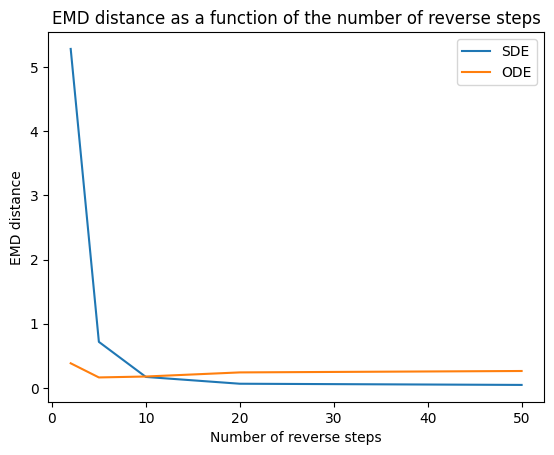

In [66]:
# now plot the EMD distance as a function of the number of reverse steps
plt.plot(timesteps, emd_sde, label='SDE')
plt.plot(timesteps, emd_ode, label='ODE')
plt.xlabel('Number of reverse steps')
plt.ylabel('EMD distance')
plt.legend()
plt.title('EMD distance as a function of the number of reverse steps')
plt.show()

# Case Study 2: Conditioning with Classifier-Free Guidance

In [1]:
import torch

def get_device():
    """
    Returns the available device ('cuda', 'mps', or 'cpu').
    """
    if torch.cuda.is_available():
        return 'cuda'
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'
    
device = get_device()
print('Device in use:', device)

Device in use: mps


**Modify the Dataset** 

Integrate class labels $y \in \{0, 1\}$ in Gaussian 2-mixture dataset

Using Gaussian Mixture dataset, with parameters mean=[-0.5, 0.0], [0.5, 0.0] and std=0.1. 10000 samples.


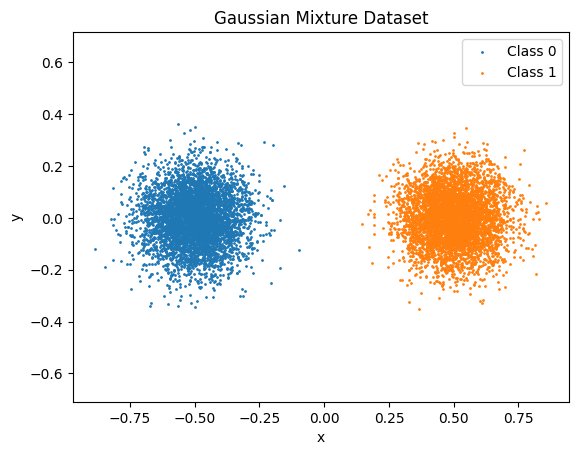

Using Gaussian Mixture dataset, with parameters mean=[-0.5, 0.0], [0.5, 0.0] and std=0.1. 10000 samples.


In [2]:
import torch

# Create a dataset with a Gaussian mixture distribution:
def get_gaussian_mixture_datapoints(mean1, mean2, std, n_samples):
    print('Using Gaussian Mixture dataset, with parameters mean=[{}, {}], [{}, {}] and std={}. {} samples.'
          .format(mean1[0], mean1[1], mean2[0], mean2[1], std, n_samples))
    # Half the samples from each mixture component.
    samples1 = torch.randn(n_samples // 2, 2) * std + mean1
    samples2 = torch.randn(n_samples - n_samples // 2, 2) * std + mean2
    samples = torch.concatenate([samples1, samples2], dim=0)
    labels = torch.zeros(n_samples)
    labels[n_samples // 2:] = 1
    return samples, labels

def get_default_gaussian_mixture_datapoints():
    mean1 = torch.tensor([-0.5, 0])
    mean2 = torch.tensor([0.5, 0])
    std = 0.1
    n_samples = 10000
    gaussian_datapoints, labels = get_gaussian_mixture_datapoints(mean1, mean2, std, n_samples)
    # shuffle the data
    perm = torch.randperm(n_samples)
    gaussian_datapoints = gaussian_datapoints[perm]
    labels = labels[perm]
    return gaussian_datapoints, labels

# random shuffle
gaussian_datapoints, labels = get_default_gaussian_mixture_datapoints()

# plot the Gaussian mixture dataset
import matplotlib.pyplot as plt
plt.scatter(gaussian_datapoints[labels == 0, 0], gaussian_datapoints[labels == 0, 1], s=1, label='Class 0')
plt.scatter(gaussian_datapoints[labels == 1, 0], gaussian_datapoints[labels == 1, 1], s=1, label='Class 1')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Gaussian Mixture Dataset')
plt.show()


# Create a TensorDataset
def create_dataset(datapoints, labels):
    dataset_obj = torch.utils.data.TensorDataset(datapoints, labels)
    return dataset_obj

def create_dataloader(dataset, batch_size):
    # Create a DataLoader
    dataloader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True
        )
    return dataloader


gaussian_datapoints, labels = get_default_gaussian_mixture_datapoints()
dataset_obj = create_dataset(gaussian_datapoints, labels)
dataloader = create_dataloader(dataset_obj, batch_size=500)

In [3]:
import math

def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

def compute_beta_t(t_norm, T, schedule = 'linear'):
    # Compute β(t) depending on schedule.
    
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        beta_t = beta_min + t_norm * (beta_max - beta_min)
    elif schedule == 'cosine':
        s = 0.008
        beta_t = (torch.pi / (T * (1 + s))) * torch.tan(((t_norm + s) / (1 + s)) * (torch.pi / 2))
    else:
        raise ValueError('Unknown schedule')
    return beta_t

def compute_alpha_bar(t_norm, schedule = 'linear'):
    if schedule == 'linear': 
        beta_min = 0.1
        beta_max = 20.0
        integrated_beta = beta_min * t_norm + 0.5 * (beta_max - beta_min) * t_norm**2
        alpha_bar = torch.exp(-  integrated_beta)
    elif schedule == 'cosine':
        alpha_bar = 0.5 * (1 - torch.cos(t_norm * torch.pi))
        s = 0.008
        alpha_bar = torch.cos((t_norm + s) / (1 + s) * (torch.pi / 2))**2
    else:
        raise ValueError('Unknown schedule')
    return alpha_bar

# must return x_t and the added noise, we will need it later to compute the loss
def forward(x_start, t, T, schedule = 'linear'):
    t_norm = t / T 
    alpha_bar = compute_alpha_bar(t_norm, schedule)
    # expand alpha_bar to the same shape as x_start, so that we can multiply them
    alpha_bar = match_last_dims(alpha_bar, x_start.shape)
    noise = torch.randn_like(x_start)
    x_t = torch.sqrt(alpha_bar)*x_start + torch.sqrt(1 - alpha_bar)*noise
    return x_t, noise

**Modify the neural network** 
* It should accept all possible class labels $y$, plus the null class label $\emptyset$, which will correspond to the *unconditional* label. It can be represented by any value you like.
* Try to use `nn.Embedding`; the model will learn to embed class labels in $\mathbb{R}^d$.

In [4]:
import model.SimpleModel as SimpleModel

simple_model_conditioned = SimpleModel.MLPModel(
    nfeatures = 2,
    time_emb_type='learnable',
    time_emb_size=8,
    nblocks = 4,
    nunits = 32,
    skip_connection = True,
    layer_norm = True,
    dropout_rate = 0.1,
    num_classes = 2
)

simple_model_conditioned = simple_model_conditioned.to(device)

# setting up the optimizer
import torch.optim as optim

optimizer = optim.AdamW(
    simple_model_conditioned.parameters(), 
    lr=2e-3, 
    betas=(0.9, 0.999))

# potentially set up a learning schedule too ...

**Modify training**

In [7]:
import torch.nn.functional as F

def training_losses(model, x_start, T, y):
    x_start = x_start.to(device)
    batch_size = x_start.shape[0]
    # Sample t uniformly from [0, T]
    t = torch.rand(batch_size, device=device) * T
    x_t, noise = forward(x_start, t, T)
    # The model takes x_t and t as input and predicts the noise. time t should be of shape (batch_size, 1)
    # we can pass normalized time to model as input
    t_norm = t / T
    t_norm = t_norm.view(-1, 1)
    y = y.view(-1, 1)
    predicted_noise = model(x_t, t_norm, y=y)
    loss = F.mse_loss(predicted_noise, noise)
    return loss

# training loop

import os

def train(
    num_epochs, 
    checkpoint_interval, 
    dataloader,
    model,
    optimizer,
    checkpoint_dir,
    device,
    T = 1
):
    print("Training on device:", device)

    # Set the model to training mode.
    model.train()
    epoch_losses = []
    for epoch in (range(1, num_epochs + 1)):
        running_loss = 0.0
        for batch_idx, (data, y) in (enumerate(dataloader)):
            data = data.to(device) 
            y = y.to(device)
            # 10% of the time, set y to null label = num_classes + 1
            y[torch.rand_like(y) < 0.1] = 2
            optimizer.zero_grad()

            # Compute the training loss.
            loss = training_losses(model, x_start=data, T=T, y = y.int())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # if batch_idx % 100 == 0:
            #     print(f"Epoch [{epoch}] Batch [{batch_idx}] Loss: {loss.item():.4f}")

        avg_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

        # Save a checkpoint every checkpoint_interval epochs.
        if epoch % checkpoint_interval == 0:
            os.makedirs(checkpoint_dir, exist_ok=True)
            checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch_losses': epoch_losses,
            }, checkpoint_path)
            print("Saved checkpoint to", checkpoint_path)

    print("Training finished.")

In [8]:
# RUN!
train(
    num_epochs=50,
    checkpoint_interval=50,
    dataloader=dataloader,
    model=simple_model_conditioned,
    optimizer=optimizer,
    checkpoint_dir='checkpoints',
    device=device
)

Training on device: mps
Epoch [1] Average Loss: 0.0708
Epoch [2] Average Loss: 0.0779
Epoch [3] Average Loss: 0.0711
Epoch [4] Average Loss: 0.0727
Epoch [5] Average Loss: 0.0760
Epoch [6] Average Loss: 0.0721
Epoch [7] Average Loss: 0.0683
Epoch [8] Average Loss: 0.0718
Epoch [9] Average Loss: 0.0692
Epoch [10] Average Loss: 0.0688
Epoch [11] Average Loss: 0.0699
Epoch [12] Average Loss: 0.0668
Epoch [13] Average Loss: 0.0692
Epoch [14] Average Loss: 0.0651
Epoch [15] Average Loss: 0.0630
Epoch [16] Average Loss: 0.0682
Epoch [17] Average Loss: 0.0626
Epoch [18] Average Loss: 0.0655
Epoch [19] Average Loss: 0.0642
Epoch [20] Average Loss: 0.0652
Epoch [21] Average Loss: 0.0637
Epoch [22] Average Loss: 0.0701
Epoch [23] Average Loss: 0.0665
Epoch [24] Average Loss: 0.0608
Epoch [25] Average Loss: 0.0632
Epoch [26] Average Loss: 0.0658
Epoch [27] Average Loss: 0.0638
Epoch [28] Average Loss: 0.0642
Epoch [29] Average Loss: 0.0621
Epoch [30] Average Loss: 0.0595
Epoch [31] Average Loss: 

**Modify the sampling algorithm** 

It should accept `guidance_scale` as argument

In [21]:
from tqdm import tqdm

def score_fn(model, x, t_norm, y):
    """
    Given the noise-predicting model, returns the score (i.e. ∇_x log p_t(x))
    at actual time t. Note that the model expects a normalized time (t/T).
    For VP: score = - (predicted noise) / sqrt(1 - ᾱ(t))
    """

    alpha_bar = compute_alpha_bar(t_norm).view(-1, *([1] * (x.dim() - 1)))
    epsilon = model(x, t_norm.view(-1, 1), y.int().view(-1, 1))
    score = - epsilon / torch.sqrt(1 - alpha_bar)
    return score

def sample(
    model,
    n_samples,
    reverse_steps,
    class_label,
    deterministic = False,
    guidance_scale = 5.0,
    schedule = 'linear',
    T = 1):
    shape = (n_samples, 2)
    xt = torch.randn(shape, device=device)
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(T, 0, reverse_steps + 1, device=device)
        for i in tqdm(range(reverse_steps)):
            t_current = t_seq[i]
            t_next = t_seq[i + 1]
            dt = t_next - t_current  # dt is negative (reverse time)
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t_current, device=device)
            t_norm_batch = t_batch / T

            
            beta_t = compute_beta_t(t_norm_batch, T, schedule)
            beta_t = beta_t.view(-1, *([1] * (xt.dim() - 1)))
            
            
            f = -0.5 * beta_t * xt
            g = torch.sqrt(beta_t)
            
            
            # Get the score (using the noise-predicting network)
            class_label = torch.tensor(class_label).to(device)
            class_label = class_label.expand_as(t_batch)
            score_cond = score_fn(model, xt, t_batch, class_label)
            
            uncond_class_label = torch.tensor(2).to(device)
            uncond_class_label = uncond_class_label.expand_as(t_batch)
            score_uncond = score_fn(model, xt, t_batch, uncond_class_label)
            
            score = guidance_scale * score_cond + (1 - guidance_scale) * score_uncond
            
            if deterministic:
                xt = xt + (f - (g**2) * score / 2) * dt
            else:
                # Euler–Maruyama update:
                #   x = x + [f - g^2 * score] dt + g * sqrt(-dt) * z,   where z ~ N(0, I)
                z = torch.randn_like(xt)
                xt = xt + (f - (g**2) * score) * dt + g * torch.sqrt(-dt) * z
            
    return xt

## Visualize Results

Visually observe what happens with increasing guidance scale. Quantify with Wasserstein metric

  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/hq/vv3v4s957cbfyk__fc9bp7x42zgcgc/T/ipykernel_20106/511377990.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_label = torch.tensor(class_label).to(device)
100%|██████████| 20/20 [00:00<00:00, 134.91it/s]


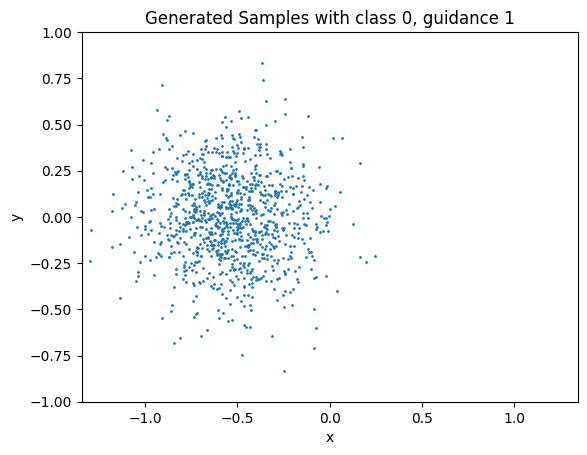

In [32]:
class_label = 0
guidance_scale = 1
samples = sample(
    model=simple_model_conditioned,
    n_samples=1000,
    reverse_steps=20,
    class_label=class_label,
    guidance_scale=guidance_scale,
    deterministic=False,
    schedule='linear',
    T=1
)
samples = samples.cpu().detach().numpy()

# plot samples
tmp_samples = samples.clip(-2, 2)
plt.scatter(tmp_samples[:, 0], tmp_samples[:, 1], s=1)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title('Generated Samples with class {}, guidance {}'.format(class_label, guidance_scale))
plt.show()

# Go further: Elucidated Diffusion Model 

(Elucidating the Design Space of Diffusion Model)

Discuss the paper with your colleagues or with me. Implement the recommend design choices, in terms of: 
* Sampling
* Network and pre-conditioning
* Training

All these design choices will require choosing the right hyper-parameters to be chosen for the working dataset. 

Typically, one does not want to go through all these troubles... there is a reason why people have settled on a default choice:
* the VP process 
* epsilon-prediction